# SysFlow Demo
Based on talk presented at FloCon 2020. Please check [abstract and presentation slides](https://flocon2020.sched.com/event/VPW3/sysflow-scalable-system-telemetry-for-improved-security-analytics) at the conference website. 

![attack](figures/attack.png) <!-- .element height="200%" width="100%" -->

In [1]:
import sys, os, json
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 75)
import matplotlib.pylab as plt
import matplotlib.dates as mdates
from sysflow.reader import FlattenedSFReader
from sysflow.formatter import SFFormatter

In [2]:
# Utility functions for highlighting dataframe rows
def highlight_path(r):
    return ['background-color: yellow' if 'exfil' in r['file.path'] else ''] * len(cols)

def highlight_ip(r):
    if r['net.dip'].startswith('104'):
        return ['background-color: yellow'] * len(_cols)
    if r['net.dip'].startswith('158'):
        return ['background-color: cyan'] * len(_cols)
    return [''] * len(_cols)

# trace sources and dataframe column selections
trace = '../../data/attacks/express/mon.1531776712.sf'
_trace = '../../data/attacks/express/mon.1531776742.sf'
cols=['ts_uts', 'endts_uts', 'type', 'opflags', 'proc.pid', 'proc.tid', 'proc.exe', 'file.path', 'flow.rbytes', 'flow.wbytes', 'container.imageid']
cols_=['ts_uts', 'type', 'opflags', 'pproc.pid', 'proc.pid', 'pproc.exe',  'proc.exe', 'proc.args']
_cols=['ts_uts', 'type', 'opflags', 'proc.pid', 'pproc.exe', 'proc.exe', 'proc.args', 'net.sip', 'net.sport', 'net.dip', 'net.dport', 'flow.rbytes', 'flow.wbytes']

In [3]:
# Initial indicator of compromise
reader = FlattenedSFReader(trace)
query = 'type = FF and file.type = f and opflags contains WRITE and proc.name pmatch (http_server_binaries)'
formatter = SFFormatter(reader, defs=['sfql/defs.yaml'])
df = formatter.toDataframe(expr=query, fields=cols)
df.style.apply(highlight_path, axis=1)

,ts_uts,endts_uts,type,opflags,proc.pid,proc.tid,proc.exe,file.path,flow.rbytes,flow.wbytes,container.imageid
0,1531776715030353952,1531776715030578781,FF,W T,2025,12406,/usr/local/bin/node,/tmp/exfil.py,0,6537,55f142ac5da7d234c7bba0662149e26bada9c6baaf504f632e13c840206fab7b


In [4]:
# Policies can also be defined and reused
reader = FlattenedSFReader(trace)
formatter = SFFormatter(reader, defs=['sfql/defs.yaml'])
df = formatter.toDataframe(expr='suspicious_webserver_writes', fields=cols)
df.style.apply(highlight_path, axis=1)

,ts_uts,endts_uts,type,opflags,proc.pid,proc.tid,proc.exe,file.path,flow.rbytes,flow.wbytes,container.imageid
0,1531776715030353952,1531776715030578781,FF,W T,2025,12406,/usr/local/bin/node,/tmp/exfil.py,0,6537,55f142ac5da7d234c7bba0662149e26bada9c6baaf504f632e13c840206fab7b


In [5]:
# Finding all process executions involving suspicious script
reader = FlattenedSFReader(trace)
query = 'type = PE and opflags = EXEC and (proc.aname contains exfil.py or proc.args contains exfil.py or file.path contains exfil.py)'
formatter = SFFormatter(reader)
df = formatter.toDataframe(expr=query, fields=cols_)
df.head(20)

,ts_uts,type,opflags,pproc.pid,proc.pid,pproc.exe,proc.exe,proc.args
0,1531776715041743005,PE,EXEC,2025,17753,/usr/local/bin/node,/bin/sh,-c /tmp/exfil.py -a
1,1531776715049024767,PE,EXEC,17753,17754,/bin/sh,/tmp/exfil.py,/tmp/exfil.py -a
2,1531776715077890260,PE,EXEC,17754,17757,/tmp/exfil.py,/tmp/exfil.py,/tmp/exfil.py -a
3,1531776715078056634,PE,EXEC,17754,17757,/tmp/exfil.py,/tmp/exfil.py,/tmp/exfil.py -a
4,1531776715078110412,PE,EXEC,17754,17757,/tmp/exfil.py,/tmp/exfil.py,/tmp/exfil.py -a
5,1531776715078162793,PE,EXEC,17754,17757,/tmp/exfil.py,/tmp/exfil.py,/tmp/exfil.py -a
6,1531776715078210871,PE,EXEC,17754,17757,/tmp/exfil.py,/tmp/exfil.py,/tmp/exfil.py -a
7,1531776715078687969,PE,EXEC,17754,17757,/tmp/exfil.py,/usr/bin/apt-get,update
8,1531776716574185341,PE,EXEC,17757,17758,/usr/bin/apt-get,/usr/bin/apt-get,--print-foreign-architectures
9,1531776718037729035,PE,EXEC,17757,17767,/usr/bin/apt-get,/usr/bin/apt-get,


In [6]:
# Finding all network flows related to suspicious script
reader = FlattenedSFReader(_trace)
query = 'type = NF and (proc.aname contains exfil.py or proc.args contains exfil.py or file.path contains exfil.py)'
formatter = SFFormatter(reader)
df = formatter.toDataframe(expr=query, fields=_cols)
df.style.apply(highlight_ip, axis=1)

,ts_uts,type,opflags,proc.pid,pproc.exe,proc.exe,proc.args,net.sip,net.sport,net.dip,net.dport,flow.rbytes,flow.wbytes
0,1531776749323345932,NF,C R C,17754,/bin/dash,/usr/bin/python2.7,/tmp/exfil.py -a,172.30.106.116,46279,172.21.0.10,53,320,0
1,1531776749324776862,NF,C R C,17754,/bin/dash,/usr/bin/python2.7,/tmp/exfil.py -a,172.30.106.116,39251,172.21.0.10,53,304,0
2,1531776749325392304,NF,C R C,17754,/bin/dash,/usr/bin/python2.7,/tmp/exfil.py -a,172.30.106.116,44331,172.21.0.10,53,296,0
3,1531776749325972739,NF,C R C,17754,/bin/dash,/usr/bin/python2.7,/tmp/exfil.py -a,172.30.106.116,49696,172.21.0.10,53,226,0
4,1531776749329986463,NF,CWR C,17754,/bin/dash,/usr/bin/python2.7,/tmp/exfil.py -a,172.30.106.116,47186,169.60.148.30,443,6382,632
5,1531776749458675855,NF,C R C,17754,/bin/dash,/usr/bin/python2.7,/tmp/exfil.py -a,172.30.106.116,46512,172.21.0.10,53,304,0
6,1531776749459347173,NF,C R C,17754,/bin/dash,/usr/bin/python2.7,/tmp/exfil.py -a,172.30.106.116,52863,172.21.0.10,53,288,0
7,1531776749460760552,NF,C R C,17754,/bin/dash,/usr/bin/python2.7,/tmp/exfil.py -a,172.30.106.116,37776,172.21.0.10,53,280,0
8,1531776749461295738,NF,C R C,17754,/bin/dash,/usr/bin/python2.7,/tmp/exfil.py -a,172.30.106.116,38725,172.21.0.10,53,205,0
9,1531776749462580967,NF,CWR C,17754,/bin/dash,/usr/bin/python2.7,/tmp/exfil.py -a,172.30.106.116,38904,158.85.156.21,443,5737,960


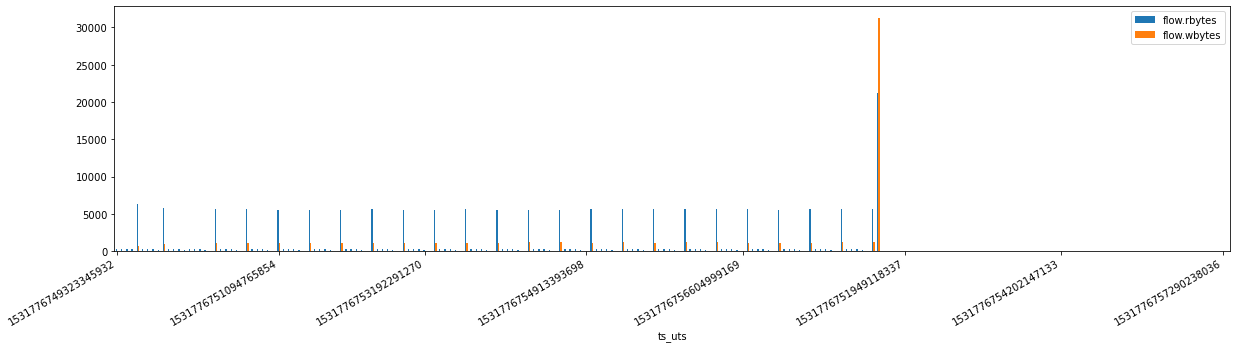

In [7]:
# Finding all network flows related to suspicious script
flows = df[(df.type.isin(['FF','NF']))]
ax = flows[['ts_uts', 'flow.rbytes', 'flow.wbytes']].plot.bar(x='ts_uts', y=['flow.rbytes','flow.wbytes'], rot=45, figsize=(20,5))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()
plt.show()

In [8]:
# Summarizing sysflow types
reader = FlattenedSFReader(trace)
formatter = SFFormatter(reader)
df = formatter.toDataframe(fields=cols)
types = df.groupby(['type']).count()[['ts_uts']].rename(columns={"ts_uts": "count"}) 
types

,count
type,
FE,3
FF,6002
NF,86
PE,234


In [9]:
# Rank ordering file operations
_df = df.replace('', np.nan).dropna(axis=0, how='any', subset=['file.path'])
paths = _df[cols].groupby(['file.path']).count()[['ts_uts']].rename(columns={"ts_uts": "count"})
paths.sort_values(by='count', ascending=False)

,count
file.path,
/etc/ld.so.cache,96
/lib/x86_64-linux-gnu/libc.so.6,48
/dev/null,20
pipe:[66729332],18
/etc/hosts,16
...,...
/var/lib/apt/lists/lock,1
/etc/services,1
/etc/apt/sources.list.d,1
